
> **Author: Krithika Devi Chandran**


In [1]:
# Import all the necessary files!
import os
import random
import numpy as np
import pandas as pd #for Reading CSV file
import matplotlib.pyplot as plt #for images Display
from matplotlib import image 

import tensorflow as tf 
from keras_preprocessing.image import ImageDataGenerator #Generating Images through Data Augmentation 
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint #CallBacks
from tensorflow.keras import models,layers,optimizers

#For Transfer Learning Technique
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

import warnings
warnings.filterwarnings('ignore')

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/My Drive/animal_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: animal_dataset/animal_dataset/train/farfalla_train/OIP-Zwx7FIbZrHjfsg055rw_BAHaE7.jpeg  
  inflating: animal_dataset/animal_dataset/train/farfalla_train/OIP-ZXlslUCo82OOxHlAotqIvwHaEK.jpeg  
  inflating: animal_dataset/animal_dataset/train/farfalla_train/OIP-zXRXv9uF7qQJ1qJuigjULwHaFj.jpeg  
  inflating: animal_dataset/animal_dataset/train/farfalla_train/OIP-ZYoAuR6Ult0soCyXXy6S8AHaHd.jpeg  
  inflating: animal_dataset/animal_dataset/train/farfalla_train/OIP-zYTwzDLkk_kueB-NEvT14AHaE8.jpeg  
  inflating: animal_dataset/animal_dataset/train/mucca_train/OIP-017eIsUPeFIH7OtCeMhj5AHaFj.jpeg  
  inflating: animal_dataset/animal_dataset/train/mucca_train/OIP-06Pazp4Kke9y83IfdQ5vQwHaFT.jpeg  
  inflating: animal_dataset/animal_dataset/train/mucca_train/OIP-07UPZG9O1AAcXB0i9jhp_QHaFj.jpeg  
  inflating: animal_dataset/animal_dataset/train/mucca_train/OIP-15lW1zrbhXHtWlYA8ZXfOQHaFj.jpeg  
  inflating: animal_dataset/animal_dataset/

In [ ]:
train_dir = "animal_dataset/animal_dataset/train"
test_dir = "animal_dataset/animal_dataset/test"

In [ ]:
print('total classes in training set', len(os.listdir(train_dir))) # No of Training Classess
print('total testing images:', len(os.listdir(test_dir))) #Number of Testing Images

In [ ]:
#List of All the Classes Present in Training Directory
train_classes = os.listdir(train_dir)
train_classes

In [ ]:
train_dir

In [ ]:
# creating directory for each class & getting names of all classes
dir=[]
names=[]
print("Total image of each class in training directory:\n")
for i,classes in enumerate(train_classes):
  dir.append(os.path.join(train_dir+"/"+classes)) #Creating Directory for Each class in Training Data
  names.append(os.listdir(train_dir+"/"+classes)) # Getting all images in each Directory
  print('Total Images of {}  is {}'.format(classes,len(names[i]))) 

In [ ]:
dir

In [ ]:
for i in range(len(train_classes)):
  plt.figure(figsize=(20,20))
  plt.subplot(1,5,i+1)
  pics = [os.path.join(dir[i], fname) for fname in names[i][:1]]
  for img_path in pics:  
    img = image.imread(img_path)
    plt.imshow(img)
    plt.xlabel(train_classes[i])

# Preprocessing

In [ ]:
img_size = 224
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., # normalize each value for each pixel for the entire vector for each input, 
                                                                                   # by converting into float value
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    subset="training",
                                                    class_mode = 'categorical', 
                                                    target_size = (img_size, img_size))

val_generator = val_datagen.flow_from_directory(train_dir,
                                                subset = "validation",
                                                batch_size = batch_size,
                                                class_mode = 'categorical', 
                                                target_size = (img_size, img_size))

In [ ]:
print("shape of the data: ", train_generator.image_shape)

In [ ]:
mobilenet_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)
mobilenet_layers.summary()

In [ ]:
model_mnet = models.Sequential()

# Add the vgg convolutional base model
model_mnet.add(mobilenet_layers)

model_mnet.add(layers.GlobalAveragePooling2D())
model_mnet.add(layers.Dropout(rate=0.3))
# add flatten layer
model_mnet.add(layers.Flatten())
# add dense layers with some dropout
model_mnet.add(layers.Dense(640, activation='relu'))
model_mnet.add(layers.BatchNormalization())
model_mnet.add(layers.Dropout(rate=0.3))
model_mnet.add(layers.Dense(320, activation='relu'))
model_mnet.add(layers.BatchNormalization())
model_mnet.add(layers.Dropout(rate=0.3))
model_mnet.add(layers.Dense(160, activation='relu'))
model_mnet.add(layers.BatchNormalization())
model_mnet.add(layers.Dropout(rate=0.3))

# add output layer
model_mnet.add(layers.Dense(5, activation='softmax'))

# compile model
model_mnet.compile(optimizer="adam", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
# view model layers
model_mnet.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [18]:
history = model_mnet.fit(train_generator,
            validation_data = val_generator,
            epochs = 30, callbacks = [early_stop])

Epoch 1/30
205/205 [==============================] - 96s 468ms/step - loss: 0.4784 - accuracy: 0.8364 - val_loss: 6.2017 - val_accuracy: 0.5220
Epoch 2/30
205/205 [==============================] - 94s 459ms/step - loss: 0.3650 - accuracy: 0.8803 - val_loss: 5.3439 - val_accuracy: 0.4701
Epoch 3/30
205/205 [==============================] - 93s 451ms/step - loss: 0.3207 - accuracy: 0.8952 - val_loss: 1.9263 - val_accuracy: 0.6630
Epoch 4/30
205/205 [==============================] - 94s 456ms/step - loss: 0.2842 - accuracy: 0.9068 - val_loss: 1.6611 - val_accuracy: 0.6514
Epoch 5/30
205/205 [==============================] - 92s 450ms/step - loss: 0.2474 - accuracy: 0.9181 - val_loss: 0.8509 - val_accuracy: 0.8028
Epoch 6/30
205/205 [==============================] - 93s 455ms/step - loss: 0.2517 - accuracy: 0.9158 - val_loss: 3.4629 - val_accuracy: 0.5391
Epoch 7/30
205/205 [==============================] - 95s 465ms/step - loss: 0.2549 - accuracy: 0.9149 - val_loss: 6.2746 - val_ac

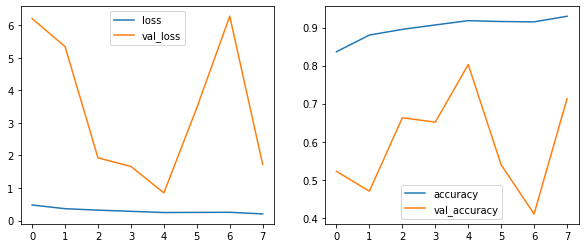

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_mn = pd.DataFrame(history.history)
history_mn[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_mn[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [23]:
loss, accuracy = model_mnet.evaluate(val_generator)
print('Test accuracy :', accuracy)

52/52 [==============================] - 7s 128ms/step - loss: 1.7259 - accuracy: 0.7131
Test accuracy : 0.7130647301673889


In [24]:
label = val_generator.classes
pred = model_mnet.predict(val_generator)
pred_class = np.argmax(pred,axis=1)

52/52 [==============================] - 5s 76ms/step


In [26]:
from sklearn.metrics import classification_report
print(classification_report(label,pred_class))

              precision    recall  f1-score   support

           0       0.14      0.11      0.12       260
           1       0.25      0.27      0.26       380
           2       0.21      0.41      0.28       336
           3       0.18      0.12      0.14       327
           4       0.18      0.08      0.11       335

    accuracy                           0.20      1638
   macro avg       0.19      0.20      0.18      1638
weighted avg       0.20      0.20      0.19      1638



In [27]:
lr = 0.001 * batch_size / 224 

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[4,8,12], 
                                                                   values=[lr, lr*0.001, lr*0.0001, lr*0.00001])


In [28]:
model_mnet.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [29]:
history_tuned = model_mnet.fit(
            train_generator,
            validation_data = val_generator,
            epochs = 10, callbacks=[early_stop])

Epoch 1/10
205/205 [==============================] - 105s 487ms/step - loss: 0.1850 - accuracy: 0.9392 - val_loss: 1.1162 - val_accuracy: 0.7882
Epoch 2/10
205/205 [==============================] - 94s 457ms/step - loss: 0.1928 - accuracy: 0.9360 - val_loss: 0.7100 - val_accuracy: 0.8516
Epoch 3/10
205/205 [==============================] - 93s 454ms/step - loss: 0.1925 - accuracy: 0.9389 - val_loss: 0.5092 - val_accuracy: 0.8822
Epoch 4/10
205/205 [==============================] - 92s 448ms/step - loss: 0.1990 - accuracy: 0.9315 - val_loss: 0.4020 - val_accuracy: 0.8962
Epoch 5/10
205/205 [==============================] - 93s 454ms/step - loss: 0.1988 - accuracy: 0.9373 - val_loss: 0.3371 - val_accuracy: 0.9127
Epoch 6/10
205/205 [==============================] - 92s 449ms/step - loss: 0.1947 - accuracy: 0.9381 - val_loss: 0.2997 - val_accuracy: 0.9176
Epoch 7/10
205/205 [==============================] - 92s 449ms/step - loss: 0.1985 - accuracy: 0.9373 - val_loss: 0.2768 - val_a

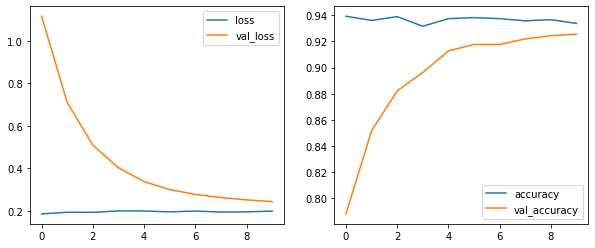

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_mn = pd.DataFrame(history_tuned.history)
history_mn[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_mn[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [32]:
loss, accuracy = model_mnet.evaluate(val_generator)
print('Test accuracy :', accuracy)

52/52 [==============================] - 5s 91ms/step - loss: 0.2428 - accuracy: 0.9255
Test accuracy : 0.9255189299583435


In [33]:
label = val_generator.classes
pred = model_mnet.predict(val_generator)
pred_class = np.argmax(pred,axis=1)

52/52 [==============================] - 5s 79ms/step


In [34]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(label, pred_class)
cf

array([[39, 57, 64, 52, 48],
       [69, 80, 80, 82, 69],
       [60, 82, 70, 57, 67],
       [56, 86, 71, 50, 64],
       [76, 73, 74, 61, 51]])